In [1]:
import numpy as np
import matplotlib as mpl
%matplotlib inline

import pandas as pd

import json
import glob
import os

In [2]:
def plot_and_save(df, name, kind='line', xlabel=None, ylabel=None, **kwargs):
    ax = df.plot(kind=kind, **kwargs)
    
    if xlabel != None:
        ax.set_xlabel(xlabel)
    if ylabel != None:
        ax.set_ylabel(ylabel)
    
    ax.legend().set_visible(False)
    mpl.pyplot.savefig("../../paper/plots/" + name + "_no_legend.png", dpi=300)
    ax.legend().set_visible(True)
    mpl.pyplot.savefig("../../paper/plots/" + name + ".png", dpi=300)
    
    df.to_csv("../../paper/plots/" + name + ".csv")
    if 'yerr' in kwargs:
        kwargs['yerr'].to_csv("../../paper/plots/" + name + "_std_err.csv")

In [3]:
data = {}

for path in glob.glob("../../data/results/lfr_params_ground_truth/*.json") + glob.glob("../../data/results/lfr_params/**/*.json", recursive=True):
  for typename, items in json.load(open(path)).items():
      if typename in data:
        for key, object_data in items.items():
          if key in data[typename]:
            data[typename][key].update(object_data)
          else:
            data[typename][key] = object_data
      else:
        data[typename] = items

frames = { typename: pd.DataFrame.from_dict(items, orient='index') for typename, items in data.items() }

In [4]:
dlslm_label = 'DSLM-Mod'
dlslm_me_label = 'DSLM-Map'
seq_postfix = ' w. Seq.'
no_contraction_postfix = ' w/o Contraction'
dlslm_ws_label = dlslm_label + seq_postfix
dlslm_nc_label = dlslm_label + no_contraction_postfix
seq_louvain_label = 'Seq. Louvain'
seq_infomap_label = 'Seq. InfoMap'
plm_label = 'PLM'
relax_map_label = 'RelaxMap'
gossip_map_label = 'GossipMap'

algo_name_mapping = {
    'synchronous local moving with map equation': dlslm_me_label,
    'synchronous local moving with modularity': dlslm_label,
    'sequential louvain': seq_louvain_label,
    'sequential infomap': seq_infomap_label,
    'relax map': relax_map_label,
    'gossip map': gossip_map_label
}

frames['algorithm_run'].replace({ 'algorithm': algo_name_mapping }, inplace=True)

frames['algorithm_run']['algorithm'] += frames['algorithm_run'].merge(frames['program_run'], left_on='program_run_id', right_index=True, how='left')['switch_to_seq'].map({ False: '', True: seq_postfix, np.NaN: '' })
frames['algorithm_run']['algorithm'] += frames['algorithm_run'].merge(frames['program_run'], left_on='program_run_id', right_index=True, how='left')['contraction'].map({ False: no_contraction_postfix, True: '', np.NaN: '' })
frames['program_run']['mu'] = pd.to_numeric(frames['program_run']['graph'].str[38]) / 10.0

In [5]:
comparison_data = frames['clustering'] \
    .merge(frames['clustering_comparison'], left_index=True, right_on='compare_clustering_id') \
    .merge(frames['algorithm_run'], left_on='algorithm_run_id', right_index=True) \
    .merge(frames['program_run'], left_on='program_run_id', right_index=True) \
    .groupby(['mu', 'algorithm'])

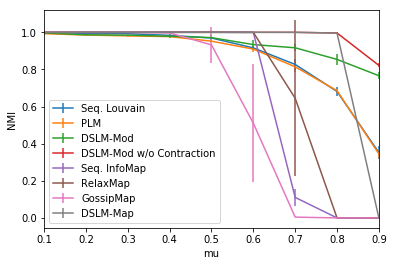

In [6]:
nmi_mean = comparison_data['NMI'].mean().to_frame().unstack() \
    ["NMI"][[seq_louvain_label, plm_label, dlslm_label, dlslm_nc_label, seq_infomap_label, relax_map_label, gossip_map_label, dlslm_me_label]]
    
nmi_err = comparison_data['NMI'].std().to_frame().unstack() \
    ["NMI"][[seq_louvain_label, plm_label, dlslm_label, dlslm_nc_label, seq_infomap_label, relax_map_label, gossip_map_label, dlslm_me_label]]

plot_and_save(nmi_mean, "quality_NMI", yerr=nmi_err, ylabel="NMI", style=['-*', '-x', '-v', '-d', '-|'])

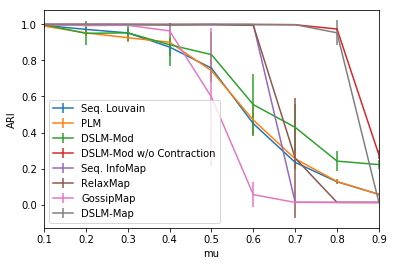

In [7]:
ari_mean = comparison_data['ARI'].mean().to_frame().unstack() \
    ["ARI"][[seq_louvain_label, plm_label, dlslm_label, dlslm_nc_label, seq_infomap_label, relax_map_label, gossip_map_label, dlslm_me_label]]
    
ari_err = comparison_data['ARI'].std().to_frame().unstack() \
    ["ARI"][[seq_louvain_label, plm_label, dlslm_label, dlslm_nc_label, seq_infomap_label, relax_map_label, gossip_map_label, dlslm_me_label]]

plot_and_save(ari_mean, "quality_ARI", yerr=ari_err, ylabel="ARI", style=['-*', '-x', '-v', '-d', '-|'])

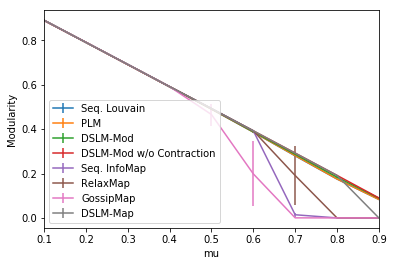

In [8]:
mod_mean = comparison_data['modularity'].mean().to_frame().unstack() \
    ["modularity"][[seq_louvain_label, plm_label, dlslm_label, dlslm_nc_label, seq_infomap_label, relax_map_label, gossip_map_label, dlslm_me_label]]
    
mod_err = comparison_data['modularity'].std().to_frame().unstack() \
    ["modularity"][[seq_louvain_label, plm_label, dlslm_label, dlslm_nc_label, seq_infomap_label, relax_map_label, gossip_map_label, dlslm_me_label]]

plot_and_save(mod_mean, "quality_modularity", yerr=mod_err, ylabel="Modularity", style=['-*', '-x', '-v', '-d', '-|'])

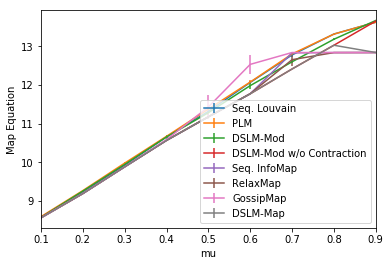

In [9]:
map_mean = comparison_data['map_equation'].mean().to_frame().unstack() \
    ["map_equation"][[seq_louvain_label, plm_label, dlslm_label, dlslm_nc_label, seq_infomap_label, relax_map_label, gossip_map_label, dlslm_me_label]]
    
map_err = comparison_data['map_equation'].std().to_frame().unstack() \
    ["map_equation"][[seq_louvain_label, plm_label, dlslm_label, dlslm_nc_label, seq_infomap_label, relax_map_label, gossip_map_label, dlslm_me_label]]

plot_and_save(map_mean, "quality_map_equation", yerr=map_err, ylabel="Map Equation", style=['-*', '-x', '-v', '-d', '-|'])